start
640 480

0: 480x640 4 cars, 1 bus, 144.0ms
Speed: 4.6ms preprocess, 144.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 bus, 106.3ms
Speed: 3.4ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 3 cars, 1 bus, 89.3ms
Speed: 2.2ms preprocess, 89.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 buss, 89.5ms
Speed: 1.8ms preprocess, 89.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 bus, 1 train, 88.7ms
Speed: 1.7ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 bus, 1 truck, 89.6ms
Speed: 1.8ms preprocess, 89.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 cars, 1 bus, 99.2ms
Speed: 1.8ms preprocess, 99.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 6

C:\Users\SystemX\AppData\Local\Temp\ipykernel_10056\2453365213.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


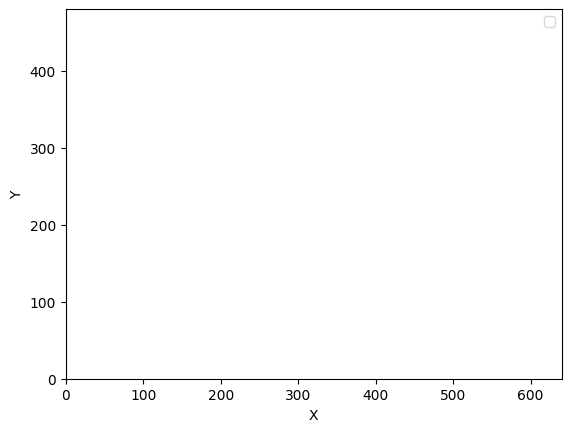

In [ ]:
from collections import defaultdict
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Загрузка модели YOLOv8
model = YOLO("yolo11n.pt")

# Путь к видео
video_path = "457701_Asia_Korea_640x480.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error opening file {video_path}")
    exit()

print("start")

# Получение FPS и размеров видео
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(width,height)

# Создание VideoWriter для записи выходного видео
output_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для записи
out = cv2.VideoWriter(output_path, fourcc, fps, (width,height))
# словарь для хранения истории трэков
track_history = defaultdict(lambda: [])
x_box = []
y_box = []

def predict_position(track, future_time, fps):
    if len(track) < 2:
        return track[-1]

    N = min(len(track), 25)
    track = np.array(track[-N:])

    times = np.arange(-N + 1, 1)

    A = np.vstack([times, np.ones(len(times))]).T
    k_x, b_x = np.linalg.lstsq(A, track[:, 0], rcond=None)[0]
    k_y, b_y = np.linalg.lstsq(A, track[:, 1], rcond=None)[0]

    future_frames = future_time * fps
    future_x = k_x * future_frames + b_x
    future_y = k_y * future_frames + b_y

    return future_x, future_y

while cap.isOpened():
    success, frame = cap.read()

    if not success:
        print("reading error")
        break

    results = model.track(frame, persist=True)

    if results[0].boxes is not None and results[0].boxes.id is not None:
         # Получение координат боксов и идентификаторов треков
        boxes = results[0].boxes.xywh.cpu() # получение координат боксов
        track_ids = results[0].boxes.id.int().cpu().tolist() # получение айдишников

        annotated_frame = results[0].plot()

        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box #координаты центра и размеры бокса
            x_box.append(int(box[0]))
            y_box.append(int(box[1]))
            track = track_history[track_id] 
            track.append((float(x), float(y))) #добавление координат в историю
            if len(track) > 30: #длина истории 30 кадров максимум
                track.pop(0)
            #рисование линий трэка
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=3)

            future_time = 1.5  # секунд
            future_x, future_y = predict_position(track, future_time, fps)

            if len(track) > 1:
                last_x, last_y = track[-1]
                cv2.line(annotated_frame, (int(last_x), int(last_y)), (int(future_x), int(future_y)), (0, 255, 255), 2)

            cv2.circle(annotated_frame, (int(future_x), int(future_y)), 5, (0, 255, 0), -1)
            cv2.putText(annotated_frame, 'Predicted', (int(future_x), int(future_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Запись кадра в выходное видео

        out.write(annotated_frame)

        cv2.imshow("YOLOv11 Tracking", annotated_frame)
    else:
        cv2.imshow("YOLOv11 Tracking", frame)

        # Запись кадра в выходное видео
        out.write(frame)

    if cv2.waitKey(1) == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

#создание графика
fig, ax = plt.subplots()
t = x_box
z = y_box
scat = ax.scatter(t[0], z[0])
ax.set(xlim=[0,width], ylim=[0, height], xlabel='X', ylabel='Y')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    return (scat)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
ani.save(filename="pillow_example.gif", writer="pillow")
#ПОСМОТРЕТЬ ПОЧЕМУ ВИДЕО НЕ ПОЛУЧАЕТСЯ И ГРАФИК